In [1]:
import sisl
from hubbard import HubbardHamiltonian, sp2, density, plot
%matplotlib inline

# Electron correlations in periodic systems

We will start by building the geometry and the TB Hamiltonian for a 1D periodic chain of Carbon atoms using `sisl`.

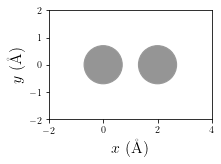

In [2]:
# Build sisl.Geometry object for a periodic 1D chain of Carbon atoms
geom = sisl.Geometry([[0,0,0], [2.,0,0]], atoms=sisl.Atom(6), sc=[4,100,10])
geom.set_nsc([3,1,1])

# Plot geometry of unit cell
p = plot.GeometryPlot(geom, cmap='Greys', figsize=(3,2))

We firstly build the TB `sisl.Hamiltonian` of `dim=2` (for spin polarized calculations)

In [3]:
# Build sisl.Hamiltonian object using sisl
H0 = sisl.Hamiltonian(geom, dim=2)
for ia in geom:
    idx = geom.close(ia, R=(0,2.1))
    H0[ia, idx[0]] = 0
    H0[ia, idx[1]] = -2.


Now one can build the `HubbardHamiltonian` object, which enables the routines stored in this class to converge the mean-field Hubbard Hamiltonian to find the self-consistent solution. To model the interaction part (Hubbard term) we will use `U=3.5` eV. 
In this case, since the system has periodic boundary conditions, the Hamiltonian will be diagonalized per $\mathbf k$-point to find the spin-densities. To do so one just need to pass the argument `nkpt=[nkx, nky, nkz]` when creating the `HubabrdHamiltonian(...)` object. This argument will set the number of $\mathbf k$-points along each direction in which the Hamiltonian will be sampled in k-space.

In [4]:
# Build the HubbardHamiltonian object with U=3.5 at room temperature
HH = HubbardHamiltonian(H0, nkpt=[100,1,1], U=3.5, kT=0.025, q=(1,1))

As in [this example](https://dipc-cc.github.io/hubbard/docs/latest/examples/molecules.html) one has to break symmetry between up and down electrons so the program can find a self-consistent solution. To do so we can place one up electron on site 0 and one down electron on site 1.

In [5]:
HH.set_polarization([0], dn=[1])

Now we can start the convergence until we find the self-consistent solution up to a desired tolerance (`tol`) by calling the `hubb.HubbardHamiltonian.converge` method. This method needs of another method to tell the code how to build the spin-densities. For instance, to compute the spin-densities for TB Hamiltonians with finite or periodic boundary conditions, one could use the method `density.calc_n`.

In [6]:
# Converge until a tolerance of tol=1e-10, print info each 10 iterations
dn = HH.converge(density.calc_n, tol=1e-10, print_info=True, steps=10)

   HubbardHamiltonian: converge towards tol=1.00e-10
   10 iterations completed: 0.0063626212646060165 -3.3444361241333893
   20 iterations completed: 0.0001918556205354749 -3.3661778892013343
   30 iterations completed: 2.7045032879868813e-13 -3.35833095919254
   found solution in 30 iterations


Also we can visualize some meaningful physical quantities and properties of the solution, e.g. such as the spin polarization of the unit-cell. Other interesting electronic properties can be visualized using the `hubbard.plot` module.


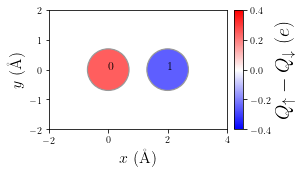

In [7]:
# Let's visualize some relevant physical quantities of the final result (this process may take a few seconds)
p = plot.SpinPolarization(HH, colorbar=True, vmax=0.4, vmin=-0.4, figsize=(4,3))
p.annotate(size=12)

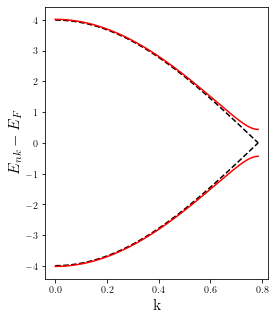

In [8]:
# Shift Hamiltonian with Fermi level to have it aligned to zero
HH.shift(-HH.fermi_level())

# Calculate bands for the bare TB Hamiltonian
band_0 = sisl.BandStructure(H0, [[0., 0., 0.], [1./2, 0., 0.]], 301, [r'$\Gamma$', 'X'])
# Also for the converged MFH Hamiltonian
band_MFH = sisl.BandStructure(HH.H, [[0., 0., 0.], [1./2, 0., 0.]], 301, [r'$\Gamma$', 'X'])

# Calculate eigenvalues of the band-structure
eigs_0 = band_0.eigh()
eigs_MFH = band_MFH.eigh()

# Plot them
import matplotlib.pyplot as plt

plt.figure(figsize=(4,5))
plt.xlabel('k', size=16)
plt.ylabel(r'$E_{nk}-E_{F}$', size=16)

# Generate linear-k for plotting (ensures correct spacing)
lband = band_0.lineark()
for i in range(eigs_0.shape[1]):
    plt.plot(lband, eigs_0[:, i], 'k--')
    plt.plot(lband, eigs_MFH[:, i], 'r')